# Hybrid Quantum-Classical Neural Networks

### Preliminaries

<img src="https://ml-esgantivar.s3.amazonaws.com/how.png" width="600px">

<img src="https://ml-esgantivar.s3.amazonaws.com/qc-schema.png" />

#### **What about backpropagation?** 

If you're familiar with classical ML, you may immediately be wondering how do we calculate gradients when quantum circuits are involved? This would be necessary to enlist powerful optimisation techniques such as gradient descent.

#### Parameter Shift-Rule

<img src="https://ml-esgantivar.s3.amazonaws.com/black-box.png" />

In the quantum case, the expectation value of a circuit with respect to an measurement operator $\hat{C}$ depends smoothly on the the circuit’s gate parameters $\theta$. 

We can write this expectation value as $\langle\hat{C}(\theta)\rangle$. This means that the derivatives $\nabla_{\theta}\langle\hat{C}\rangle$ exist and gradient descent can be used.


Before digging deeper, we will first set establish some basic notation. For simplicity, though a circuit may contain many gates, we can concentrate on just a single gate $\hat{U}$ that we want to differentiate (other gates will follow the same pattern).

<img src="https://ml-esgantivar.s3.amazonaws.com/explain-1.png" width="600px">

All gates appearing before $\hat{U}$ can be absorbed into an initial state preparation $\left|\psi_{0}\right\rangle$, and all gates appearing after $\hat{U}$ scan be absorbed with the measurement operator $\hat{C}$ to make a new effective measurement operator $\hat{A}$. The expectation value $\hat{A}$ in the simpler one-gate circuit is identical to the expectation value $\hat{C}$ in the larger circuit.








We can also write any unitary gate in the form

$$\hat{U}(\theta)=e^{i \theta \hat{V}}$$

where $\hat{V}$ is the Hermitian generator of the gate $\hat{U}$.

Now, how do we actually obtain the numerical values of the gradient necessary for gradient descent?

In short, the parameter-shift rule says that for many gates of interest—including all single-qubit gates—we can obtain the value of the derivative $\nabla_{\theta}\langle\hat{A}(\theta)\rangle$ by subtracting two related circuit evaluations:

$$\nabla_{\theta}\langle\hat{A}\rangle=u\left[\left\langle\hat{A}\left(\theta+\frac{\pi}{4 u}\right)\right\rangle-\left\langle\hat{A}\left(\theta-\frac{\pi}{4 u}\right)\right\rangle\right]$$


<img src="https://ml-esgantivar.s3.amazonaws.com/explain-2.png" width="600px">

So... Lets code!

In [1]:
!pip install qiskit -q
!pip install pylatexenc -q

In [21]:
import torch
import torchvision
import itertools
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Function
from torchvision import datasets, transforms

In [22]:
import qiskit
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer

In [23]:
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
np.random.seed = 42

NUM_QUBITS = 4
NUM_SHOTS = 10000
SHIFT = np.pi/2
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [25]:
def create_QC_OUTPUTS():
    # for this circuit, there are only 2 outputs: '0' and '1'
    return ['0', '1']

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0', '1']


### Define Quantum Circuit

The expectaction value of the circuit are propabilities of execute n shots with the provided backend

In [60]:
class QiskitCircuit():
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits, 1)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(0)
        for k in range(n_qubits-1):
            self.circuit.cx(k, k+1)
            
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)
        self.circuit.barrier()

        for i in reversed(range(n_qubits-1)):
            self.circuit.cx(i, i+1)
        self.circuit.h(0)
        self.circuit.measure(0,0)
        # ---------------------------
        
        self.backend = backend
        self.shots = shots

        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        # print(f'params: {i}')
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,
                          self.backend,
                          shots=self.shots,
                          parameter_binds = [{self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}])
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots, 1)

Expected value for rotation ['pi/1', 'pi/2', 'pi/4', 'pi/8']: [0.497 0.503]


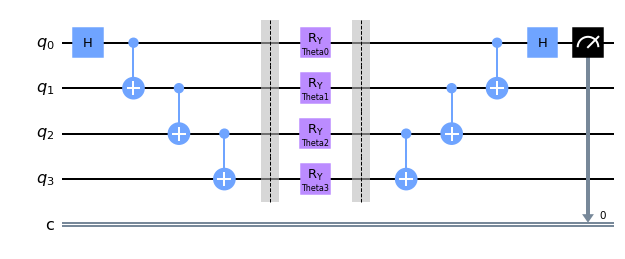

In [61]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
test_params = [np.pi / 2**k for k in range(NUM_QUBITS)]
test_names = ['pi/{}'.format(2**k) for k in range (NUM_QUBITS)]
print('Expected value for rotation {}: {}'.format(test_names, circuit.run(torch.Tensor(test_params))))
circuit.circuit.draw(output='mpl')

In [62]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        ## simply apply the circuit and calculate expected value
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        result = torch.tensor([exp_value])
        ctx.save_for_backward(result, i)
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        ## calc gradient using shift rule with give SHIFT value
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)
        return (result.float() * grad_output.float()).T

In [63]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.7548, 0.2452]], dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([ 0.0007, -0.0025, -0.0012, -0.0036])


100%|██████████| 100/100 [00:15<00:00,  6.66it/s]


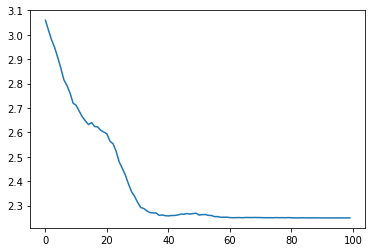

In [64]:
qc = TorchCircuit.apply

def cost(x):
    target = -1
    expval = qc(x)[0]
    val = sum([(i+1)*expval[i] for i in range(2)]) / 2
    return torch.abs(val - target) ** 2, expval

x = torch.tensor(test_params, requires_grad=True)
opt = torch.optim.Adam([x], lr=.05)

num_epoch = 100

loss_list = []
expval_list = []

for i in tqdm(range(num_epoch)):
# for i in range(num_epoch):
    opt.zero_grad()
    loss, expval = cost(x)
    loss.backward()
    opt.step()
    loss_list.append(loss.item())
    expval_list.append(expval)

plt.plot(loss_list)

### Load MNIST [0, 1]

Training dataset

In [58]:
# Concentrating on the first 100 samples
n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 2)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

Test dataset

In [59]:
n_samples = 200

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 2)[0][n_samples:], 
                np.where(X_test.targets == 1)[0][n_samples:])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

### Define Neural Network with Quantum Layer

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.fc3 = nn.Linear(1, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        x = qc(x[0]) # QUANTUM LAYER
        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)

Create model

In [32]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

### Training 

In [33]:
epochs = 2
loss_list = []
loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()        
        # Forward pass
        output = network(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

Training [50%]	Loss: 1.2251
Training [100%]	Loss: 1.1929


Text(0, 0.5, 'Cross Entropy Loss')

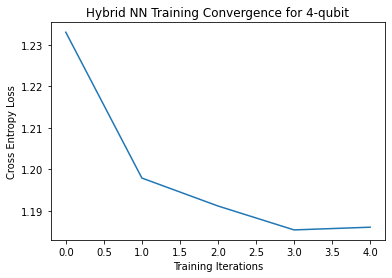

In [27]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

### Test accuracy of NN

In [28]:
accuracy = 0
number = 0
for batch_idx, (data, target) in enumerate(test_loader):
    number +=1
    output = network.predict(data).item()
    accuracy += (output == target[0].item())*1

In [29]:
"Performance on test data is is: {}/{} = {}%".format(accuracy,number,100*accuracy/number)

'Performance on test data is is: 1692/1715 = 98.65889212827989%'

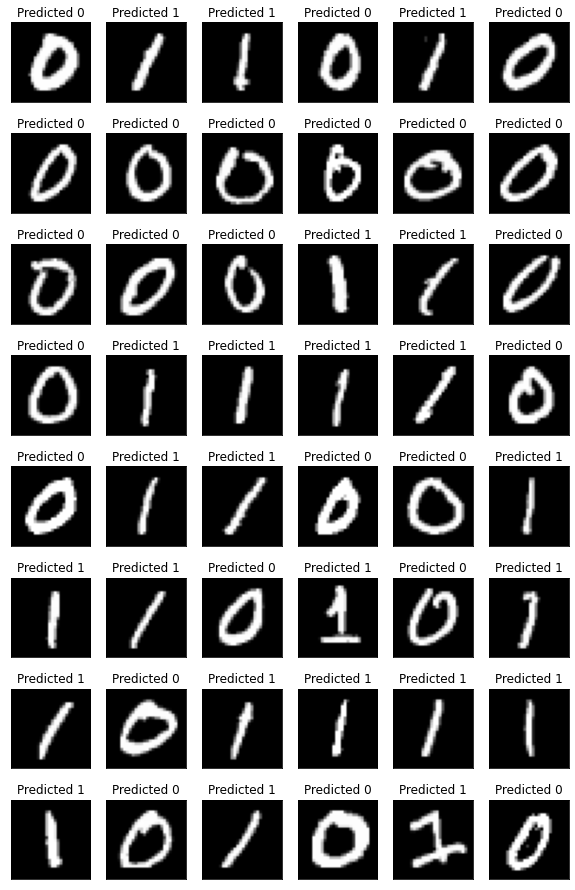

In [30]:
n_samples_shape = (8, 6)
count = 0
fig, axes = plt.subplots(nrows=n_samples_shape[0], ncols=n_samples_shape[1], figsize=(10, 2*n_samples_shape[0]))

network.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_shape[0]*n_samples_shape[1]:
            break
        pred = network.predict(data).item()

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_xticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_yticks([])
        axes[count//n_samples_shape[1]][count%n_samples_shape[1]].set_title('Predicted {}'.format(pred))
        
        count += 1

### Some interesting Applications

#### **Hybrid Quantum-Classical Convolutional Neural Networks**

Available on [arxiv](https://arxiv.org/pdf/1911.02998.pdf)

<img src="https://ml-esgantivar.s3.amazonaws.com/cnn-neural.png" style="max-width: 500px">

### References
* [Quantum Deep Learning with Qiskit](https://github.com/liangqiyao990210/Quantum-Deep-Learning)
* [The Stochastic Parameter-Shift Rule](https://pennylane.ai/qml/demos/tutorial_stochastic_parameter_shift.html)
* [Hybrid quantum-classical Neural Networks with PyTorch and Qiskit](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html)